# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

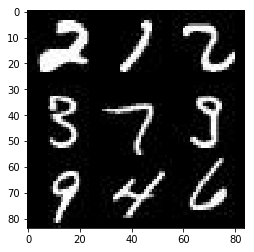

In [2]:
show_n_images = 9

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

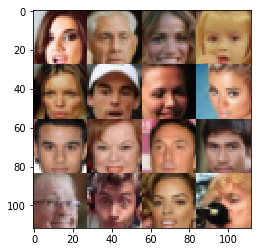

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # create the placeholder for real_inputs. First dimension in tuple = 'None', which is confusing, but means
    # we can have ANY number of instances in the batch
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                name='inputs_real')
    
    # create the placeholder for the z inputs. These will be used by the generator to generate images
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    
    # create the learning rate.
    learn_rate = tf.placeholder(tf.float32, (None), name="learning_rate")
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # set my alpha value for the leaky relu - using the same as the Udacity DCGAN walkthrough
    alpha = 0.2
    # reviewer comment - try using dropout in discriminator with low rate of dropping.
    # use dropout after each conv layer except the last and definitely not after the fc layer
    # reviewer comment - try using xavier initialisation. NOTE for the discriminator, the only one that
    # is a fully connected layer is the first one, so this is the only one to initialise.
    # DCFW Note - am playing around with the order of bn/relu/drop. Previously was b/r/d - now trying r/d/b
    # as per https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout-in-tensorflow
    dropout_rate = 0.95
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input layer is 28*28*3 for the celebs, 28*28*1 for the MNIST
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # don't apply the batch normalisation to the input layer
        x1 = tf.maximum(alpha * x1, x1) # leaky relu process
        x1 = tf.nn.dropout(x1, keep_prob=dropout_rate) # drop process
        # layer is now 14 * 14 * 64 (i.e. convoluted stack of 'images' of 14*14 across 64 filters)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True) # batch normalization layer
        x2 = tf.maximum(alpha * x2, x2) # leaky relu layer
        x2 = tf.nn.dropout(x2, keep_prob=dropout_rate) # dropout layer
        # print('x2.shape is {}'.format(x2.shape))
        # layer is now 7 * 7 * 128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same') # convolution layer
        x3 = tf.layers.batch_normalization(x3, training=True) # batch normalization layer
        x3 = tf.maximum(alpha * x3, x3) # leaky relu layer
        # NOT used dropping at this layer, following reviewer comment - 
        # don't use it on last conv layer.
        print('x3.shape is {}'.format(x3.shape))
        # layer is now 4*4* 256 (or maybe 3*3? * 256)
        
        # Flatten this final tensor
        flat = tf.reshape(x3, (-1, 4*4*256)) # will find out here if my dimension calcs are correct
        print('flat.shape is {}'.format(flat.shape))
        logits = tf.layers.dense(flat, 1) # output to one because it is a simple yes/no as to whether it is a "True" pic
        out = tf.sigmoid(logits)
        
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use the retry module or similar alternatives.
x3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
x3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # set my alpha level for the leaky relus - using the same as the Udacity DCGAN walk-through
    alpha = 0.2
    
    # reviewer comment - try using xavier intialisation for the weights. For the generator there are several
    # fully connected layers - use it for each?
    # reviwer3 comment - DON'T save the xavier_weights as a variable and then apply it to each, as it will use 
    # the same weights in each, thus losing all stochastic behaviour
    
    # reviewer3 comment - use dropout as per discriminator. Also trying to order the processes differently.
    dropout_rate = 0.95
    
    with tf.variable_scope("generator", reuse=not is_train):
        # this threw me for AGES - see Slack channel. You want to set reuse to True when is_training is False and
        # vice versa. When you are training you don't re-use the variables.
        # Reviewer suggestion - use 3 layers (previously had 2) - suggests 512, 256, 128 to output.
        
        # create first, fully connected layer
        x1_dense = tf.layers.dense(z, 7*7*512) # match the discriminator - work backwards
        
        # reshape it into a convolutional tensor and start the convolutional stack.
        x1 = tf.reshape(x1_dense, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training= is_train) # batch norm process
        x1 = tf.maximum(alpha * x1, x1) # leaky relu process
        x1 = tf.nn.dropout(x1, keep_prob=dropout_rate) # dropout process
        # print("x1.shape is {}".format(x1.shape))
        # layer is 7 * 7 * 512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2, training=is_train) # batch norm process
        x2 = tf.maximum(alpha * x2, x2) # leaky relu process
        x2 = tf.nn.dropout(x2, keep_prob=dropout_rate) # dropout process
        #print("x2.shape is {}".format(x2.shape))
        # layer is now 14 * 14 * 256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3, training=is_train) # batch norm process
        x3 = tf.maximum(alpha * x3, x3) # leaky relu process
        x3 = tf.nn.dropout(x3, keep_prob=dropout_rate) # dropout process
        # print("x3.shape is {}".format(x3.shape))
        # layer is now 28 * 28  * 128
        
        # create the output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # this is how we solve for the different RGB channel dimension diffs between the MNIST and celeba
        # as the number of 'filters' is now the number of channels. Same thing.
        # Note we need to set the strides at 1, as the image shape is already 28 * 28 and we don't want to increase
        # it to 56*56.
        # layer is now 28 * 28 * 3 or 28 * 28 * 1
        #print('logits has shape: {}'.format(logits.shape))
        
        out = tf.tanh(logits)
    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # reviewer #2 comment - try using smoothing on discriminator labels to improve performance
    smooth =0.15
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # reviewer comment - to try to prevent the discriminator from being too strong, only the discriminator labels
    # (one-sided) are reduced from 1 to 0.9. This is known as one-sided label smoothing.
    # generation is a much harder task, so this is to prevent the discriminator being too strong
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels = tf.ones_like(d_model_real) * (1-smooth))
    )
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels = tf.zeros_like(d_model_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    # NOTE - only the discriminator labels are smoothed, NOT the generator labels (see above)
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    ) 
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

x3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
x3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    tvars = tf.trainable_variables()
    
    d_vars = [var for var in tvars if var.name.startswith('discriminator')]
    #print(d_vars)
    g_vars = [var for var in tvars if var.name.startswith('generator')]
    #print(g_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt= tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt= tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     saver = tf.train.Saver()
    
    # create the inputs placeholders etc using the model_inputs function
    # see playground cell below to see how I found out the dimensions
    inputs_real, inputs_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # create the losses using the model_loss function
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    
    # optimize those losses using the model_opt() function
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate=learning_rate, beta1=beta1)

    losses = []
    # note - I have the losses in a list, but I don't actually return them at the end. This is because I don't
    # want to mess around with the Udacity cells when the code is run to generate figures etc. It's for future
    # projects, to remind me to store the losses to create graphs of training loss vs epochs
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                
                # TODO: Train Model
                # from Slack channel - the batch_images have data in range -0.5 to +0.5, so double them to get the image
                batch_images = batch_images *2
                
                
                # create random noise z_inputs to seed the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images,
                                                   inputs_z: batch_z,
                                                   learn_rate: learning_rate
                })
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images,
                                                    inputs_z: batch_z,
                                                    learn_rate: learning_rate
                    
                })
                
                # calculate loss every 25 batches?
                if steps % 25 == 0:
                    train_loss_d = d_loss.eval(feed_dict={
                        inputs_real: batch_images,
                        inputs_z: batch_z
                    })
                    train_loss_g = g_loss.eval(feed_dict={
                        inputs_z: batch_z
                    })
                    print('Epoch: {}'.format(epoch_i + 1), end=", ")
                    print('Batch: {}'.format(steps), end=": ")
                    print('Discr train loss: {:.3f}'.format(train_loss_d), end=", ")
                    print('Gen train loss: {:.3f}'.format(train_loss_g))
                    
                    # save losses to view after training:
                    losses.append((train_loss_d, train_loss_g))
                
                # show the images created every 100 batches?
                if steps % 100 == 0:
                    # as per instructions, run the show_generator_output every 100 batches
                    show_generator_output(sess, n_images=16, input_z=inputs_z, out_channel_dim=data_shape[3],
                                         image_mode=data_image_mode)
        #saver.save(sess, './checkpoints/generator.ckpt')
                

In [12]:
# DCFW created playground cell to find out attributes etc.
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print (mnist_dataset.shape) # finding the dimensions - need this for the inputs

(60000, 28, 28, 1)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

following comments from reviewer, looked at [Radford paper](https://arxiv.org/abs/1511.06434) for hyperparameter suggestions.

x3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
x3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Epoch: 1, Batch: 25: Discr train loss: 0.444, Gen train loss: 9.772
Epoch: 1, Batch: 50: Discr train loss: 0.947, Gen train loss: 2.043
Epoch: 1, Batch: 75: Discr train loss: 2.177, Gen train loss: 0.269
Epoch: 1, Batch: 100: Discr train loss: 1.336, Gen train loss: 1.237


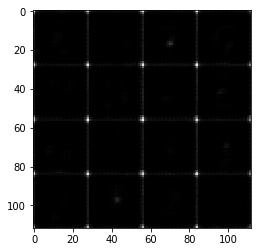

Epoch: 1, Batch: 125: Discr train loss: 1.427, Gen train loss: 0.620
Epoch: 1, Batch: 150: Discr train loss: 1.215, Gen train loss: 1.053
Epoch: 1, Batch: 175: Discr train loss: 1.576, Gen train loss: 1.746
Epoch: 1, Batch: 200: Discr train loss: 1.262, Gen train loss: 0.862


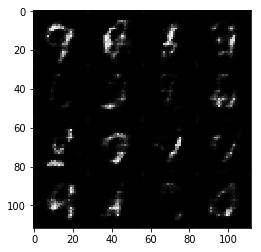

Epoch: 1, Batch: 225: Discr train loss: 1.451, Gen train loss: 0.523
Epoch: 1, Batch: 250: Discr train loss: 1.155, Gen train loss: 0.884
Epoch: 1, Batch: 275: Discr train loss: 1.036, Gen train loss: 1.206
Epoch: 1, Batch: 300: Discr train loss: 1.169, Gen train loss: 1.039


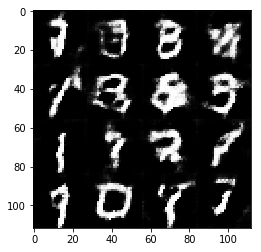

Epoch: 1, Batch: 325: Discr train loss: 1.381, Gen train loss: 1.940
Epoch: 1, Batch: 350: Discr train loss: 0.988, Gen train loss: 1.121
Epoch: 1, Batch: 375: Discr train loss: 0.830, Gen train loss: 1.529
Epoch: 1, Batch: 400: Discr train loss: 1.265, Gen train loss: 1.530


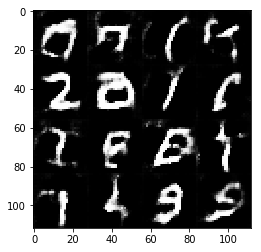

Epoch: 1, Batch: 425: Discr train loss: 1.366, Gen train loss: 0.595
Epoch: 1, Batch: 450: Discr train loss: 1.883, Gen train loss: 0.289
Epoch: 1, Batch: 475: Discr train loss: 1.529, Gen train loss: 0.478
Epoch: 1, Batch: 500: Discr train loss: 1.462, Gen train loss: 0.538


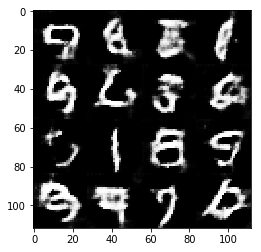

Epoch: 1, Batch: 525: Discr train loss: 1.272, Gen train loss: 0.698
Epoch: 1, Batch: 550: Discr train loss: 1.203, Gen train loss: 1.016
Epoch: 1, Batch: 575: Discr train loss: 1.371, Gen train loss: 1.225
Epoch: 1, Batch: 600: Discr train loss: 1.390, Gen train loss: 1.870


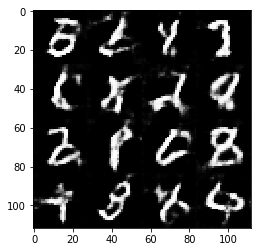

Epoch: 1, Batch: 625: Discr train loss: 1.420, Gen train loss: 0.532
Epoch: 1, Batch: 650: Discr train loss: 1.406, Gen train loss: 0.605
Epoch: 1, Batch: 675: Discr train loss: 1.963, Gen train loss: 0.289
Epoch: 1, Batch: 700: Discr train loss: 1.275, Gen train loss: 0.786


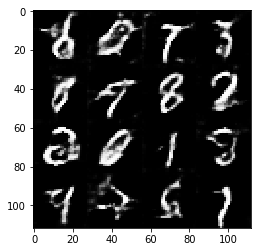

Epoch: 1, Batch: 725: Discr train loss: 1.278, Gen train loss: 1.400
Epoch: 1, Batch: 750: Discr train loss: 1.374, Gen train loss: 0.578
Epoch: 1, Batch: 775: Discr train loss: 1.283, Gen train loss: 0.675
Epoch: 1, Batch: 800: Discr train loss: 1.401, Gen train loss: 0.519


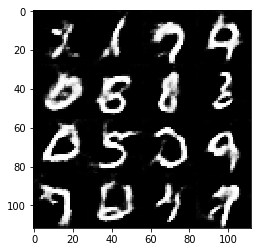

Epoch: 1, Batch: 825: Discr train loss: 1.099, Gen train loss: 1.054
Epoch: 1, Batch: 850: Discr train loss: 1.142, Gen train loss: 0.875
Epoch: 1, Batch: 875: Discr train loss: 1.612, Gen train loss: 1.661
Epoch: 1, Batch: 900: Discr train loss: 1.211, Gen train loss: 0.827


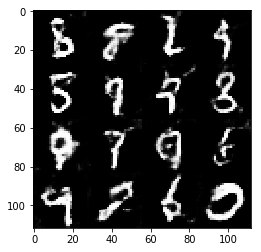

Epoch: 1, Batch: 925: Discr train loss: 1.222, Gen train loss: 0.795
Epoch: 1, Batch: 950: Discr train loss: 1.504, Gen train loss: 0.536
Epoch: 1, Batch: 975: Discr train loss: 1.018, Gen train loss: 1.231
Epoch: 1, Batch: 1000: Discr train loss: 1.185, Gen train loss: 1.242


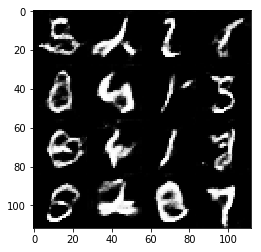

Epoch: 1, Batch: 1025: Discr train loss: 1.260, Gen train loss: 1.104
Epoch: 1, Batch: 1050: Discr train loss: 1.239, Gen train loss: 0.989
Epoch: 1, Batch: 1075: Discr train loss: 1.492, Gen train loss: 0.512
Epoch: 1, Batch: 1100: Discr train loss: 1.390, Gen train loss: 2.034


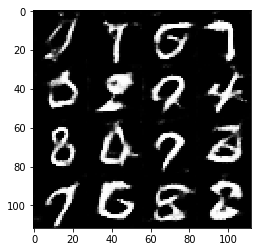

Epoch: 1, Batch: 1125: Discr train loss: 1.650, Gen train loss: 0.416
Epoch: 1, Batch: 1150: Discr train loss: 1.294, Gen train loss: 0.745
Epoch: 1, Batch: 1175: Discr train loss: 1.303, Gen train loss: 1.727
Epoch: 1, Batch: 1200: Discr train loss: 1.344, Gen train loss: 0.592


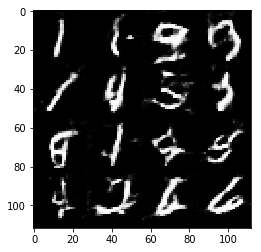

Epoch: 1, Batch: 1225: Discr train loss: 1.140, Gen train loss: 0.925
Epoch: 1, Batch: 1250: Discr train loss: 0.985, Gen train loss: 0.981
Epoch: 1, Batch: 1275: Discr train loss: 1.172, Gen train loss: 1.530
Epoch: 1, Batch: 1300: Discr train loss: 1.385, Gen train loss: 0.578


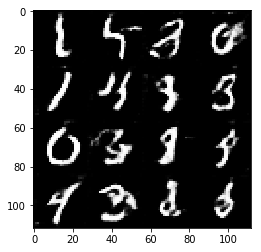

Epoch: 1, Batch: 1325: Discr train loss: 1.117, Gen train loss: 0.796
Epoch: 1, Batch: 1350: Discr train loss: 1.376, Gen train loss: 1.334
Epoch: 1, Batch: 1375: Discr train loss: 1.132, Gen train loss: 0.983
Epoch: 1, Batch: 1400: Discr train loss: 1.230, Gen train loss: 0.755


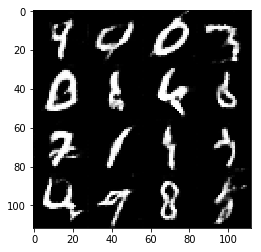

Epoch: 1, Batch: 1425: Discr train loss: 1.585, Gen train loss: 0.486
Epoch: 1, Batch: 1450: Discr train loss: 1.070, Gen train loss: 0.969
Epoch: 1, Batch: 1475: Discr train loss: 1.320, Gen train loss: 1.158
Epoch: 1, Batch: 1500: Discr train loss: 1.106, Gen train loss: 1.401


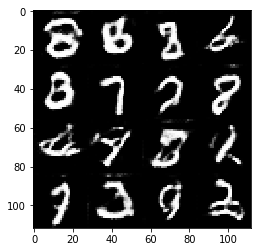

Epoch: 1, Batch: 1525: Discr train loss: 1.161, Gen train loss: 1.666
Epoch: 1, Batch: 1550: Discr train loss: 1.118, Gen train loss: 0.827
Epoch: 1, Batch: 1575: Discr train loss: 1.094, Gen train loss: 1.330
Epoch: 1, Batch: 1600: Discr train loss: 1.126, Gen train loss: 0.910


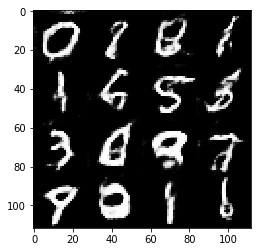

Epoch: 1, Batch: 1625: Discr train loss: 1.021, Gen train loss: 0.998
Epoch: 1, Batch: 1650: Discr train loss: 1.126, Gen train loss: 1.991
Epoch: 1, Batch: 1675: Discr train loss: 1.042, Gen train loss: 1.061
Epoch: 1, Batch: 1700: Discr train loss: 1.086, Gen train loss: 0.809


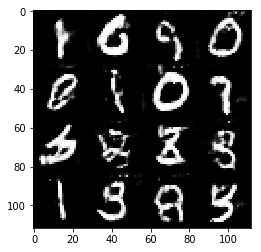

Epoch: 1, Batch: 1725: Discr train loss: 1.098, Gen train loss: 0.981
Epoch: 1, Batch: 1750: Discr train loss: 1.002, Gen train loss: 1.617
Epoch: 1, Batch: 1775: Discr train loss: 0.847, Gen train loss: 1.615
Epoch: 1, Batch: 1800: Discr train loss: 0.842, Gen train loss: 1.543


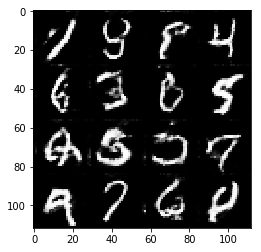

Epoch: 1, Batch: 1825: Discr train loss: 1.273, Gen train loss: 0.632
Epoch: 1, Batch: 1850: Discr train loss: 1.211, Gen train loss: 0.727
Epoch: 1, Batch: 1875: Discr train loss: 1.274, Gen train loss: 0.633
Epoch: 2, Batch: 1900: Discr train loss: 0.939, Gen train loss: 1.604


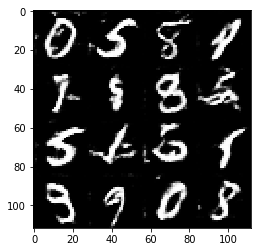

Epoch: 2, Batch: 1925: Discr train loss: 1.247, Gen train loss: 0.669
Epoch: 2, Batch: 1950: Discr train loss: 0.867, Gen train loss: 1.284
Epoch: 2, Batch: 1975: Discr train loss: 0.970, Gen train loss: 1.349
Epoch: 2, Batch: 2000: Discr train loss: 1.179, Gen train loss: 1.287


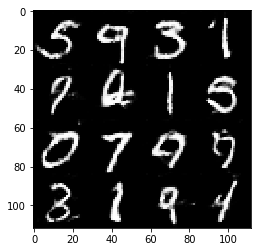

Epoch: 2, Batch: 2025: Discr train loss: 1.271, Gen train loss: 2.050
Epoch: 2, Batch: 2050: Discr train loss: 1.171, Gen train loss: 0.809
Epoch: 2, Batch: 2075: Discr train loss: 0.959, Gen train loss: 1.746
Epoch: 2, Batch: 2100: Discr train loss: 0.829, Gen train loss: 1.579


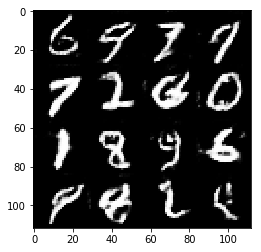

Epoch: 2, Batch: 2125: Discr train loss: 1.011, Gen train loss: 1.089
Epoch: 2, Batch: 2150: Discr train loss: 1.350, Gen train loss: 0.678
Epoch: 2, Batch: 2175: Discr train loss: 0.934, Gen train loss: 1.202
Epoch: 2, Batch: 2200: Discr train loss: 1.469, Gen train loss: 2.668


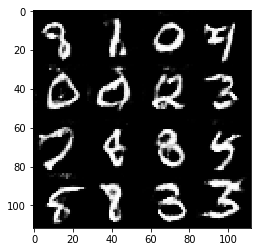

Epoch: 2, Batch: 2225: Discr train loss: 1.265, Gen train loss: 0.698
Epoch: 2, Batch: 2250: Discr train loss: 1.378, Gen train loss: 2.277
Epoch: 2, Batch: 2275: Discr train loss: 0.780, Gen train loss: 1.689
Epoch: 2, Batch: 2300: Discr train loss: 1.077, Gen train loss: 0.964


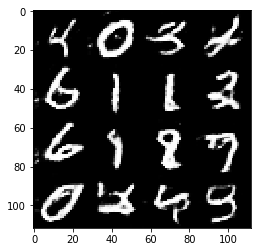

Epoch: 2, Batch: 2325: Discr train loss: 1.603, Gen train loss: 0.429
Epoch: 2, Batch: 2350: Discr train loss: 0.881, Gen train loss: 1.296
Epoch: 2, Batch: 2375: Discr train loss: 0.818, Gen train loss: 1.895
Epoch: 2, Batch: 2400: Discr train loss: 1.012, Gen train loss: 1.157


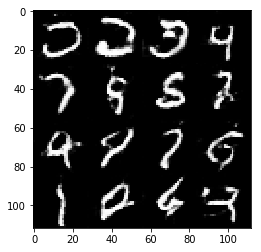

Epoch: 2, Batch: 2425: Discr train loss: 0.792, Gen train loss: 1.296
Epoch: 2, Batch: 2450: Discr train loss: 0.831, Gen train loss: 1.341
Epoch: 2, Batch: 2475: Discr train loss: 1.645, Gen train loss: 0.474
Epoch: 2, Batch: 2500: Discr train loss: 1.036, Gen train loss: 1.410


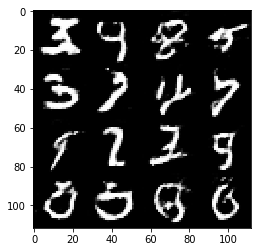

Epoch: 2, Batch: 2525: Discr train loss: 1.240, Gen train loss: 0.679
Epoch: 2, Batch: 2550: Discr train loss: 1.027, Gen train loss: 0.985
Epoch: 2, Batch: 2575: Discr train loss: 1.205, Gen train loss: 0.933
Epoch: 2, Batch: 2600: Discr train loss: 0.790, Gen train loss: 1.751


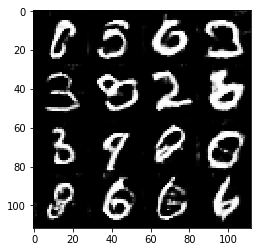

Epoch: 2, Batch: 2625: Discr train loss: 0.996, Gen train loss: 1.088
Epoch: 2, Batch: 2650: Discr train loss: 0.813, Gen train loss: 1.744
Epoch: 2, Batch: 2675: Discr train loss: 0.899, Gen train loss: 1.946
Epoch: 2, Batch: 2700: Discr train loss: 0.881, Gen train loss: 1.794


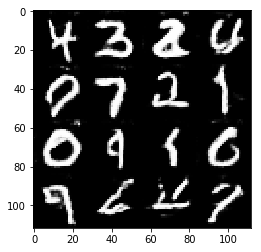

Epoch: 2, Batch: 2725: Discr train loss: 0.828, Gen train loss: 1.687
Epoch: 2, Batch: 2750: Discr train loss: 1.084, Gen train loss: 1.985
Epoch: 2, Batch: 2775: Discr train loss: 1.582, Gen train loss: 0.663
Epoch: 2, Batch: 2800: Discr train loss: 1.128, Gen train loss: 0.864


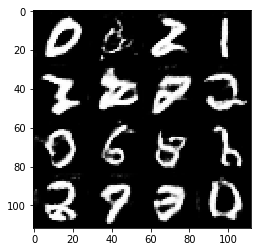

Epoch: 2, Batch: 2825: Discr train loss: 0.843, Gen train loss: 1.567
Epoch: 2, Batch: 2850: Discr train loss: 1.829, Gen train loss: 0.475
Epoch: 2, Batch: 2875: Discr train loss: 1.445, Gen train loss: 2.530
Epoch: 2, Batch: 2900: Discr train loss: 0.916, Gen train loss: 1.145


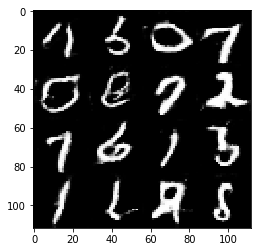

Epoch: 2, Batch: 2925: Discr train loss: 1.014, Gen train loss: 2.072
Epoch: 2, Batch: 2950: Discr train loss: 1.145, Gen train loss: 0.893
Epoch: 2, Batch: 2975: Discr train loss: 0.804, Gen train loss: 1.760
Epoch: 2, Batch: 3000: Discr train loss: 1.017, Gen train loss: 0.924


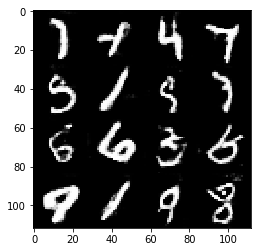

Epoch: 2, Batch: 3025: Discr train loss: 0.932, Gen train loss: 1.452
Epoch: 2, Batch: 3050: Discr train loss: 0.844, Gen train loss: 1.422
Epoch: 2, Batch: 3075: Discr train loss: 0.693, Gen train loss: 1.731
Epoch: 2, Batch: 3100: Discr train loss: 0.748, Gen train loss: 1.549


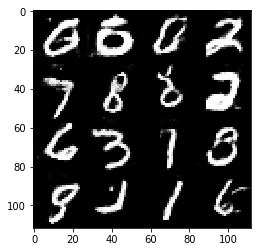

Epoch: 2, Batch: 3125: Discr train loss: 1.278, Gen train loss: 0.602
Epoch: 2, Batch: 3150: Discr train loss: 0.888, Gen train loss: 1.264
Epoch: 2, Batch: 3175: Discr train loss: 0.819, Gen train loss: 1.265
Epoch: 2, Batch: 3200: Discr train loss: 0.764, Gen train loss: 1.526


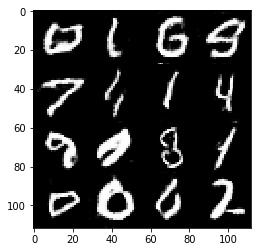

Epoch: 2, Batch: 3225: Discr train loss: 0.823, Gen train loss: 2.449
Epoch: 2, Batch: 3250: Discr train loss: 0.868, Gen train loss: 1.349
Epoch: 2, Batch: 3275: Discr train loss: 1.544, Gen train loss: 0.603
Epoch: 2, Batch: 3300: Discr train loss: 0.800, Gen train loss: 1.416


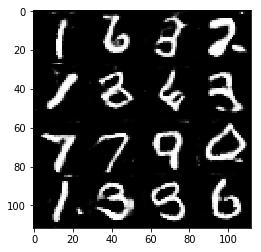

Epoch: 2, Batch: 3325: Discr train loss: 0.878, Gen train loss: 1.026
Epoch: 2, Batch: 3350: Discr train loss: 0.756, Gen train loss: 1.416
Epoch: 2, Batch: 3375: Discr train loss: 0.848, Gen train loss: 2.138
Epoch: 2, Batch: 3400: Discr train loss: 0.741, Gen train loss: 1.541


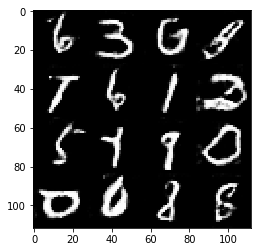

Epoch: 2, Batch: 3425: Discr train loss: 1.261, Gen train loss: 0.968
Epoch: 2, Batch: 3450: Discr train loss: 2.237, Gen train loss: 0.320
Epoch: 2, Batch: 3475: Discr train loss: 0.715, Gen train loss: 1.876
Epoch: 2, Batch: 3500: Discr train loss: 0.996, Gen train loss: 1.130


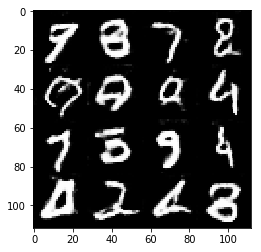

Epoch: 2, Batch: 3525: Discr train loss: 0.941, Gen train loss: 1.288
Epoch: 2, Batch: 3550: Discr train loss: 1.476, Gen train loss: 0.684
Epoch: 2, Batch: 3575: Discr train loss: 0.960, Gen train loss: 1.182
Epoch: 2, Batch: 3600: Discr train loss: 1.119, Gen train loss: 0.880


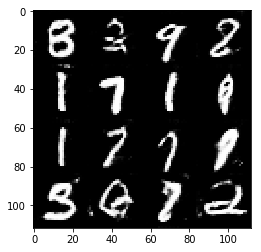

Epoch: 2, Batch: 3625: Discr train loss: 0.851, Gen train loss: 2.157
Epoch: 2, Batch: 3650: Discr train loss: 0.682, Gen train loss: 1.756
Epoch: 2, Batch: 3675: Discr train loss: 1.209, Gen train loss: 0.776
Epoch: 2, Batch: 3700: Discr train loss: 1.442, Gen train loss: 0.680


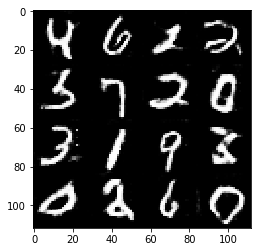

Epoch: 2, Batch: 3725: Discr train loss: 0.839, Gen train loss: 1.315
Epoch: 2, Batch: 3750: Discr train loss: 1.294, Gen train loss: 0.874


In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

x3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
x3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Epoch: 1, Batch: 25: Discr train loss: 0.755, Gen train loss: 3.073
Epoch: 1, Batch: 50: Discr train loss: 1.269, Gen train loss: 1.510
Epoch: 1, Batch: 75: Discr train loss: 1.508, Gen train loss: 3.683
Epoch: 1, Batch: 100: Discr train loss: 0.787, Gen train loss: 1.611


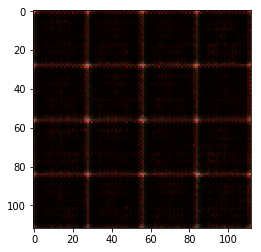

Epoch: 1, Batch: 125: Discr train loss: 0.757, Gen train loss: 1.649
Epoch: 1, Batch: 150: Discr train loss: 0.650, Gen train loss: 2.168
Epoch: 1, Batch: 175: Discr train loss: 1.420, Gen train loss: 1.963
Epoch: 1, Batch: 200: Discr train loss: 1.313, Gen train loss: 0.656


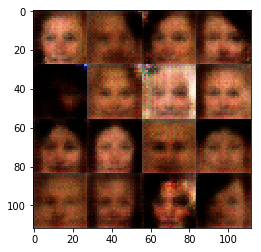

Epoch: 1, Batch: 225: Discr train loss: 0.968, Gen train loss: 1.540
Epoch: 1, Batch: 250: Discr train loss: 0.997, Gen train loss: 1.712
Epoch: 1, Batch: 275: Discr train loss: 1.115, Gen train loss: 1.383
Epoch: 1, Batch: 300: Discr train loss: 1.609, Gen train loss: 1.464


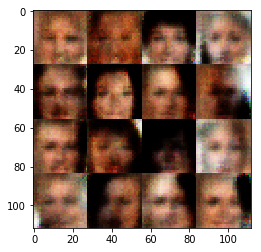

Epoch: 1, Batch: 325: Discr train loss: 1.618, Gen train loss: 2.524
Epoch: 1, Batch: 350: Discr train loss: 3.095, Gen train loss: 2.847
Epoch: 1, Batch: 375: Discr train loss: 0.992, Gen train loss: 1.031
Epoch: 1, Batch: 400: Discr train loss: 1.761, Gen train loss: 0.337


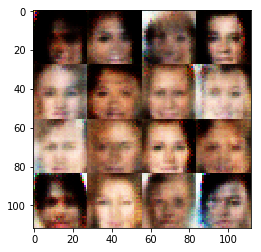

Epoch: 1, Batch: 425: Discr train loss: 1.280, Gen train loss: 0.684
Epoch: 1, Batch: 450: Discr train loss: 1.193, Gen train loss: 1.487
Epoch: 1, Batch: 475: Discr train loss: 1.192, Gen train loss: 0.895
Epoch: 1, Batch: 500: Discr train loss: 1.166, Gen train loss: 0.846


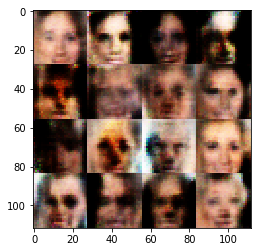

Epoch: 1, Batch: 525: Discr train loss: 1.164, Gen train loss: 1.083
Epoch: 1, Batch: 550: Discr train loss: 1.381, Gen train loss: 2.222
Epoch: 1, Batch: 575: Discr train loss: 1.116, Gen train loss: 1.110
Epoch: 1, Batch: 600: Discr train loss: 1.102, Gen train loss: 0.815


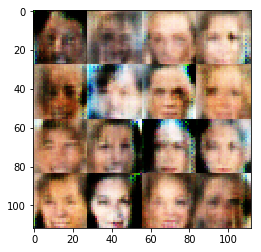

Epoch: 1, Batch: 625: Discr train loss: 1.451, Gen train loss: 0.960
Epoch: 1, Batch: 650: Discr train loss: 1.828, Gen train loss: 2.046
Epoch: 1, Batch: 675: Discr train loss: 0.950, Gen train loss: 1.069
Epoch: 1, Batch: 700: Discr train loss: 1.778, Gen train loss: 1.698


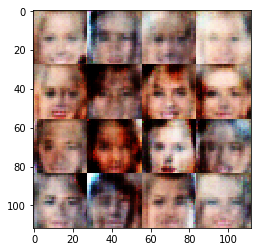

Epoch: 1, Batch: 725: Discr train loss: 1.327, Gen train loss: 0.697
Epoch: 1, Batch: 750: Discr train loss: 1.428, Gen train loss: 0.627
Epoch: 1, Batch: 775: Discr train loss: 1.084, Gen train loss: 1.209
Epoch: 1, Batch: 800: Discr train loss: 2.093, Gen train loss: 2.326


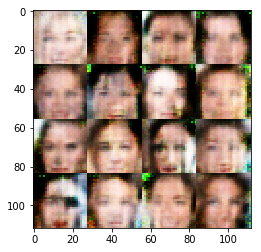

Epoch: 1, Batch: 825: Discr train loss: 1.343, Gen train loss: 0.772
Epoch: 1, Batch: 850: Discr train loss: 1.637, Gen train loss: 0.461
Epoch: 1, Batch: 875: Discr train loss: 1.435, Gen train loss: 0.771
Epoch: 1, Batch: 900: Discr train loss: 1.480, Gen train loss: 0.623


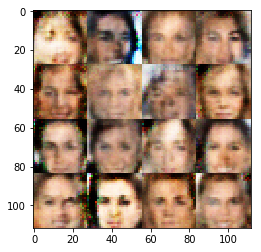

Epoch: 1, Batch: 925: Discr train loss: 1.205, Gen train loss: 1.805
Epoch: 1, Batch: 950: Discr train loss: 1.303, Gen train loss: 0.967
Epoch: 1, Batch: 975: Discr train loss: 1.399, Gen train loss: 0.729
Epoch: 1, Batch: 1000: Discr train loss: 1.389, Gen train loss: 0.891


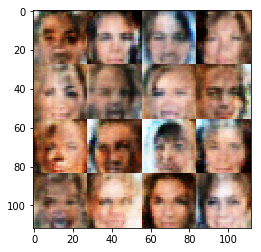

Epoch: 1, Batch: 1025: Discr train loss: 1.276, Gen train loss: 0.795
Epoch: 1, Batch: 1050: Discr train loss: 1.285, Gen train loss: 1.040
Epoch: 1, Batch: 1075: Discr train loss: 0.989, Gen train loss: 1.252
Epoch: 1, Batch: 1100: Discr train loss: 1.340, Gen train loss: 0.789


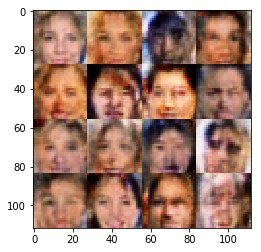

Epoch: 1, Batch: 1125: Discr train loss: 2.140, Gen train loss: 2.328
Epoch: 1, Batch: 1150: Discr train loss: 1.269, Gen train loss: 0.761
Epoch: 1, Batch: 1175: Discr train loss: 1.373, Gen train loss: 0.628
Epoch: 1, Batch: 1200: Discr train loss: 1.292, Gen train loss: 1.221


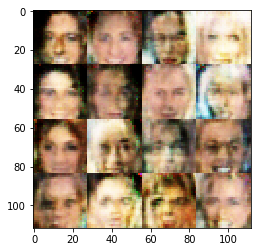

Epoch: 1, Batch: 1225: Discr train loss: 1.131, Gen train loss: 0.922
Epoch: 1, Batch: 1250: Discr train loss: 1.515, Gen train loss: 0.470
Epoch: 1, Batch: 1275: Discr train loss: 1.042, Gen train loss: 1.187
Epoch: 1, Batch: 1300: Discr train loss: 1.398, Gen train loss: 0.603


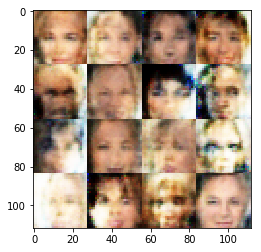

Epoch: 1, Batch: 1325: Discr train loss: 1.215, Gen train loss: 1.346
Epoch: 1, Batch: 1350: Discr train loss: 1.092, Gen train loss: 1.054
Epoch: 1, Batch: 1375: Discr train loss: 1.415, Gen train loss: 0.637
Epoch: 1, Batch: 1400: Discr train loss: 1.269, Gen train loss: 0.835


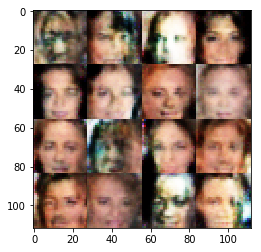

Epoch: 1, Batch: 1425: Discr train loss: 2.308, Gen train loss: 2.369
Epoch: 1, Batch: 1450: Discr train loss: 1.135, Gen train loss: 1.185
Epoch: 1, Batch: 1475: Discr train loss: 1.066, Gen train loss: 1.035
Epoch: 1, Batch: 1500: Discr train loss: 1.844, Gen train loss: 0.640


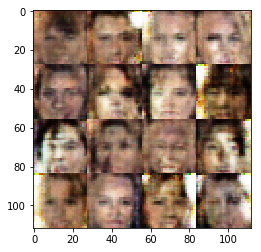

Epoch: 1, Batch: 1525: Discr train loss: 1.218, Gen train loss: 1.237
Epoch: 1, Batch: 1550: Discr train loss: 1.229, Gen train loss: 0.857
Epoch: 1, Batch: 1575: Discr train loss: 1.374, Gen train loss: 0.721
Epoch: 1, Batch: 1600: Discr train loss: 1.121, Gen train loss: 1.108


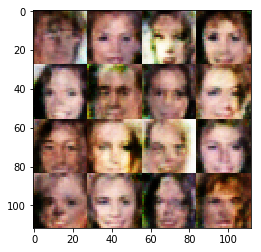

Epoch: 1, Batch: 1625: Discr train loss: 1.280, Gen train loss: 0.720
Epoch: 1, Batch: 1650: Discr train loss: 1.458, Gen train loss: 0.798
Epoch: 1, Batch: 1675: Discr train loss: 1.355, Gen train loss: 0.666
Epoch: 1, Batch: 1700: Discr train loss: 1.419, Gen train loss: 0.516


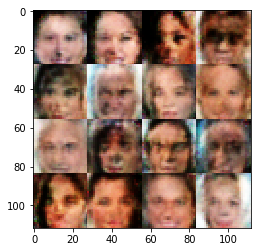

Epoch: 1, Batch: 1725: Discr train loss: 1.295, Gen train loss: 0.722
Epoch: 1, Batch: 1750: Discr train loss: 1.329, Gen train loss: 0.598
Epoch: 1, Batch: 1775: Discr train loss: 1.363, Gen train loss: 1.041
Epoch: 1, Batch: 1800: Discr train loss: 1.458, Gen train loss: 1.072


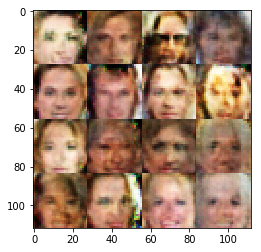

Epoch: 1, Batch: 1825: Discr train loss: 1.412, Gen train loss: 1.016
Epoch: 1, Batch: 1850: Discr train loss: 1.446, Gen train loss: 1.363
Epoch: 1, Batch: 1875: Discr train loss: 1.157, Gen train loss: 0.902
Epoch: 1, Batch: 1900: Discr train loss: 1.385, Gen train loss: 0.919


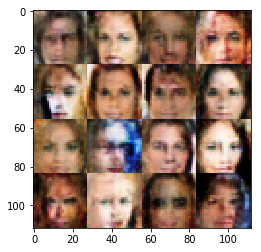

Epoch: 1, Batch: 1925: Discr train loss: 1.469, Gen train loss: 0.539
Epoch: 1, Batch: 1950: Discr train loss: 1.343, Gen train loss: 1.650
Epoch: 1, Batch: 1975: Discr train loss: 1.472, Gen train loss: 0.530
Epoch: 1, Batch: 2000: Discr train loss: 1.318, Gen train loss: 0.883


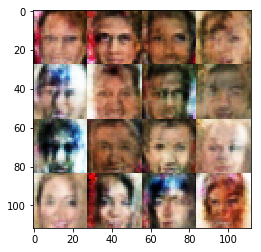

Epoch: 1, Batch: 2025: Discr train loss: 1.445, Gen train loss: 0.730
Epoch: 1, Batch: 2050: Discr train loss: 1.570, Gen train loss: 0.926
Epoch: 1, Batch: 2075: Discr train loss: 1.400, Gen train loss: 1.117
Epoch: 1, Batch: 2100: Discr train loss: 1.180, Gen train loss: 0.948


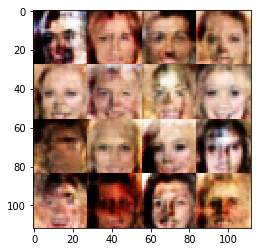

Epoch: 1, Batch: 2125: Discr train loss: 1.327, Gen train loss: 0.722
Epoch: 1, Batch: 2150: Discr train loss: 1.327, Gen train loss: 0.606
Epoch: 1, Batch: 2175: Discr train loss: 1.411, Gen train loss: 0.748
Epoch: 1, Batch: 2200: Discr train loss: 1.359, Gen train loss: 0.741


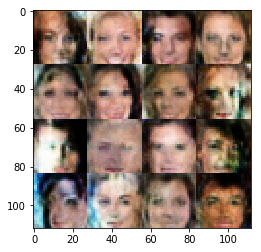

Epoch: 1, Batch: 2225: Discr train loss: 1.294, Gen train loss: 0.784
Epoch: 1, Batch: 2250: Discr train loss: 1.372, Gen train loss: 0.563
Epoch: 1, Batch: 2275: Discr train loss: 1.457, Gen train loss: 0.595
Epoch: 1, Batch: 2300: Discr train loss: 1.421, Gen train loss: 0.573


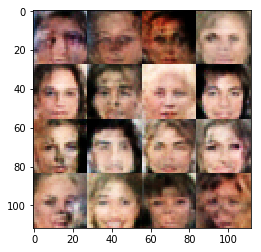

Epoch: 1, Batch: 2325: Discr train loss: 1.490, Gen train loss: 0.496
Epoch: 1, Batch: 2350: Discr train loss: 1.118, Gen train loss: 0.808
Epoch: 1, Batch: 2375: Discr train loss: 1.609, Gen train loss: 0.446
Epoch: 1, Batch: 2400: Discr train loss: 1.313, Gen train loss: 0.829


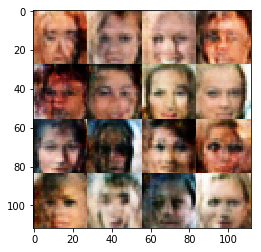

Epoch: 1, Batch: 2425: Discr train loss: 1.439, Gen train loss: 0.696
Epoch: 1, Batch: 2450: Discr train loss: 1.260, Gen train loss: 0.981
Epoch: 1, Batch: 2475: Discr train loss: 1.278, Gen train loss: 0.742
Epoch: 1, Batch: 2500: Discr train loss: 1.379, Gen train loss: 0.865


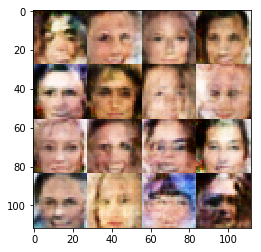

Epoch: 1, Batch: 2525: Discr train loss: 1.342, Gen train loss: 0.881
Epoch: 1, Batch: 2550: Discr train loss: 1.408, Gen train loss: 0.644
Epoch: 1, Batch: 2575: Discr train loss: 1.381, Gen train loss: 0.819
Epoch: 1, Batch: 2600: Discr train loss: 1.389, Gen train loss: 0.752


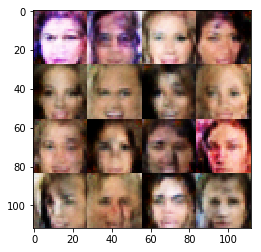

Epoch: 1, Batch: 2625: Discr train loss: 1.099, Gen train loss: 1.032
Epoch: 1, Batch: 2650: Discr train loss: 1.214, Gen train loss: 0.801
Epoch: 1, Batch: 2675: Discr train loss: 1.249, Gen train loss: 0.667
Epoch: 1, Batch: 2700: Discr train loss: 1.343, Gen train loss: 0.827


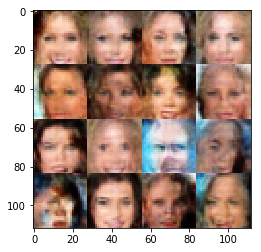

Epoch: 1, Batch: 2725: Discr train loss: 1.237, Gen train loss: 0.888
Epoch: 1, Batch: 2750: Discr train loss: 1.166, Gen train loss: 0.981
Epoch: 1, Batch: 2775: Discr train loss: 1.373, Gen train loss: 1.031
Epoch: 1, Batch: 2800: Discr train loss: 1.241, Gen train loss: 0.980


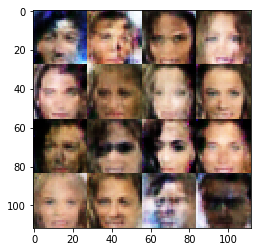

Epoch: 1, Batch: 2825: Discr train loss: 1.289, Gen train loss: 0.801
Epoch: 1, Batch: 2850: Discr train loss: 1.301, Gen train loss: 0.814
Epoch: 1, Batch: 2875: Discr train loss: 1.270, Gen train loss: 0.749
Epoch: 1, Batch: 2900: Discr train loss: 1.497, Gen train loss: 0.632


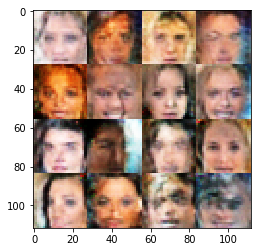

Epoch: 1, Batch: 2925: Discr train loss: 1.456, Gen train loss: 0.732
Epoch: 1, Batch: 2950: Discr train loss: 1.365, Gen train loss: 0.801
Epoch: 1, Batch: 2975: Discr train loss: 1.346, Gen train loss: 0.847
Epoch: 1, Batch: 3000: Discr train loss: 1.298, Gen train loss: 0.772


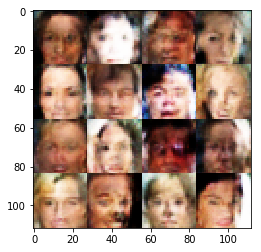

Epoch: 1, Batch: 3025: Discr train loss: 1.349, Gen train loss: 1.171
Epoch: 1, Batch: 3050: Discr train loss: 1.310, Gen train loss: 0.665
Epoch: 1, Batch: 3075: Discr train loss: 1.349, Gen train loss: 0.714
Epoch: 1, Batch: 3100: Discr train loss: 1.098, Gen train loss: 1.048


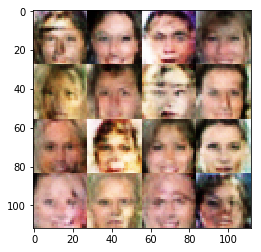

Epoch: 1, Batch: 3125: Discr train loss: 1.396, Gen train loss: 0.624
Epoch: 1, Batch: 3150: Discr train loss: 1.398, Gen train loss: 0.663
Epoch: 1, Batch: 3175: Discr train loss: 1.523, Gen train loss: 0.484
Epoch: 1, Batch: 3200: Discr train loss: 1.492, Gen train loss: 1.100


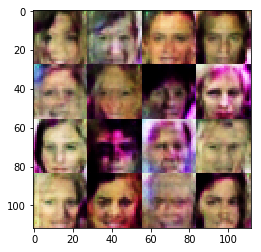

Epoch: 1, Batch: 3225: Discr train loss: 1.269, Gen train loss: 0.711
Epoch: 1, Batch: 3250: Discr train loss: 1.332, Gen train loss: 0.630
Epoch: 1, Batch: 3275: Discr train loss: 1.425, Gen train loss: 0.838
Epoch: 1, Batch: 3300: Discr train loss: 1.597, Gen train loss: 0.455


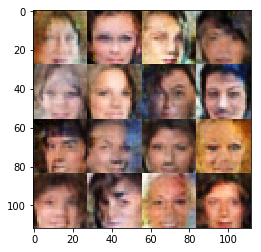

Epoch: 1, Batch: 3325: Discr train loss: 1.326, Gen train loss: 0.914
Epoch: 1, Batch: 3350: Discr train loss: 1.438, Gen train loss: 1.196
Epoch: 1, Batch: 3375: Discr train loss: 1.425, Gen train loss: 0.538
Epoch: 1, Batch: 3400: Discr train loss: 1.451, Gen train loss: 0.660


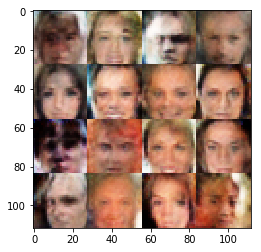

Epoch: 1, Batch: 3425: Discr train loss: 1.244, Gen train loss: 0.741
Epoch: 1, Batch: 3450: Discr train loss: 1.291, Gen train loss: 1.054
Epoch: 1, Batch: 3475: Discr train loss: 1.352, Gen train loss: 0.764
Epoch: 1, Batch: 3500: Discr train loss: 1.358, Gen train loss: 0.864


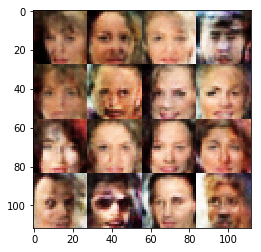

Epoch: 1, Batch: 3525: Discr train loss: 1.520, Gen train loss: 0.585
Epoch: 1, Batch: 3550: Discr train loss: 1.422, Gen train loss: 0.681
Epoch: 1, Batch: 3575: Discr train loss: 1.323, Gen train loss: 0.753
Epoch: 1, Batch: 3600: Discr train loss: 1.359, Gen train loss: 0.725


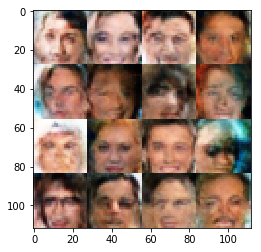

Epoch: 1, Batch: 3625: Discr train loss: 1.268, Gen train loss: 0.784
Epoch: 1, Batch: 3650: Discr train loss: 1.425, Gen train loss: 0.836
Epoch: 1, Batch: 3675: Discr train loss: 1.335, Gen train loss: 0.720
Epoch: 1, Batch: 3700: Discr train loss: 1.500, Gen train loss: 0.480


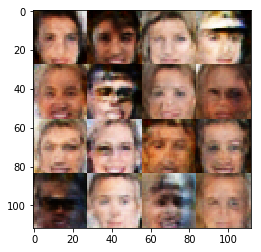

Epoch: 1, Batch: 3725: Discr train loss: 1.198, Gen train loss: 0.794
Epoch: 1, Batch: 3750: Discr train loss: 1.315, Gen train loss: 0.668
Epoch: 1, Batch: 3775: Discr train loss: 1.376, Gen train loss: 0.816
Epoch: 1, Batch: 3800: Discr train loss: 1.362, Gen train loss: 0.826


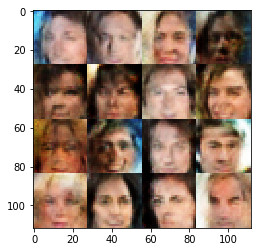

Epoch: 1, Batch: 3825: Discr train loss: 1.394, Gen train loss: 0.690
Epoch: 1, Batch: 3850: Discr train loss: 1.261, Gen train loss: 0.948
Epoch: 1, Batch: 3875: Discr train loss: 1.370, Gen train loss: 1.244
Epoch: 1, Batch: 3900: Discr train loss: 1.426, Gen train loss: 1.341


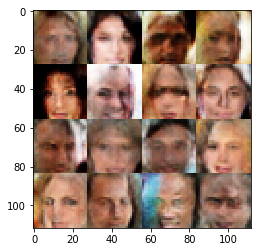

Epoch: 1, Batch: 3925: Discr train loss: 1.384, Gen train loss: 0.829
Epoch: 1, Batch: 3950: Discr train loss: 1.323, Gen train loss: 0.832
Epoch: 1, Batch: 3975: Discr train loss: 1.385, Gen train loss: 0.915
Epoch: 1, Batch: 4000: Discr train loss: 1.159, Gen train loss: 0.854


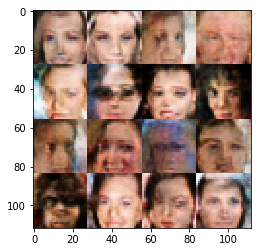

Epoch: 1, Batch: 4025: Discr train loss: 1.311, Gen train loss: 0.934
Epoch: 1, Batch: 4050: Discr train loss: 1.254, Gen train loss: 0.727
Epoch: 1, Batch: 4075: Discr train loss: 1.396, Gen train loss: 0.938
Epoch: 1, Batch: 4100: Discr train loss: 1.245, Gen train loss: 0.975


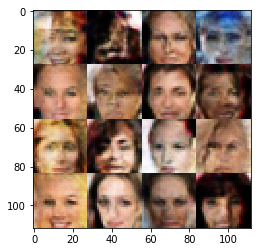

Epoch: 1, Batch: 4125: Discr train loss: 1.280, Gen train loss: 1.372
Epoch: 1, Batch: 4150: Discr train loss: 1.385, Gen train loss: 0.562
Epoch: 1, Batch: 4175: Discr train loss: 1.353, Gen train loss: 0.685
Epoch: 1, Batch: 4200: Discr train loss: 1.446, Gen train loss: 0.706


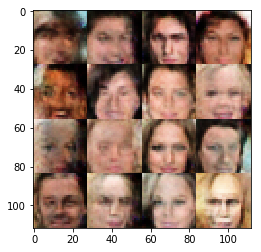

Epoch: 1, Batch: 4225: Discr train loss: 1.338, Gen train loss: 0.580
Epoch: 1, Batch: 4250: Discr train loss: 1.259, Gen train loss: 0.915
Epoch: 1, Batch: 4275: Discr train loss: 1.267, Gen train loss: 0.942
Epoch: 1, Batch: 4300: Discr train loss: 1.305, Gen train loss: 0.835


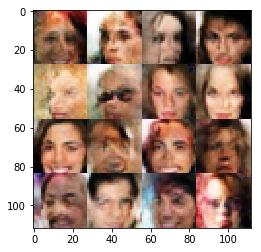

Epoch: 1, Batch: 4325: Discr train loss: 1.273, Gen train loss: 1.138
Epoch: 1, Batch: 4350: Discr train loss: 1.423, Gen train loss: 0.575
Epoch: 1, Batch: 4375: Discr train loss: 1.326, Gen train loss: 0.843
Epoch: 1, Batch: 4400: Discr train loss: 1.356, Gen train loss: 0.727


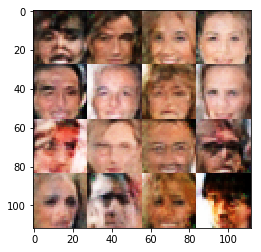

Epoch: 1, Batch: 4425: Discr train loss: 1.500, Gen train loss: 0.478
Epoch: 1, Batch: 4450: Discr train loss: 1.391, Gen train loss: 0.690
Epoch: 1, Batch: 4475: Discr train loss: 1.479, Gen train loss: 1.015
Epoch: 1, Batch: 4500: Discr train loss: 1.238, Gen train loss: 0.900


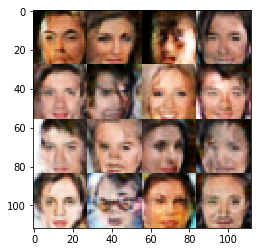

Epoch: 1, Batch: 4525: Discr train loss: 1.355, Gen train loss: 0.724
Epoch: 1, Batch: 4550: Discr train loss: 1.393, Gen train loss: 0.663
Epoch: 1, Batch: 4575: Discr train loss: 1.348, Gen train loss: 0.800
Epoch: 1, Batch: 4600: Discr train loss: 1.387, Gen train loss: 0.849


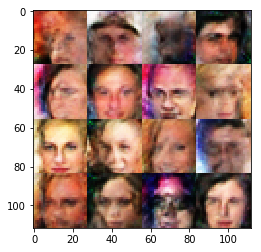

Epoch: 1, Batch: 4625: Discr train loss: 1.435, Gen train loss: 0.647
Epoch: 1, Batch: 4650: Discr train loss: 1.298, Gen train loss: 0.735
Epoch: 1, Batch: 4675: Discr train loss: 1.329, Gen train loss: 0.740
Epoch: 1, Batch: 4700: Discr train loss: 1.369, Gen train loss: 0.780


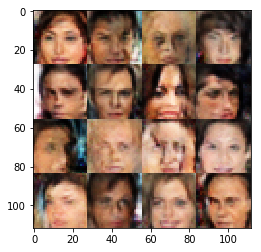

Epoch: 1, Batch: 4725: Discr train loss: 1.384, Gen train loss: 0.670
Epoch: 1, Batch: 4750: Discr train loss: 1.289, Gen train loss: 0.867
Epoch: 1, Batch: 4775: Discr train loss: 1.376, Gen train loss: 1.389
Epoch: 1, Batch: 4800: Discr train loss: 1.437, Gen train loss: 0.649


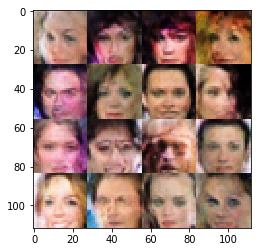

Epoch: 1, Batch: 4825: Discr train loss: 1.295, Gen train loss: 0.756
Epoch: 1, Batch: 4850: Discr train loss: 1.607, Gen train loss: 0.483
Epoch: 1, Batch: 4875: Discr train loss: 1.441, Gen train loss: 0.482
Epoch: 1, Batch: 4900: Discr train loss: 1.307, Gen train loss: 0.708


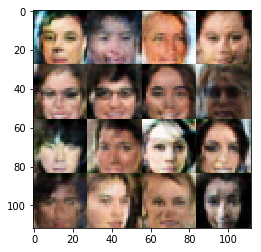

Epoch: 1, Batch: 4925: Discr train loss: 1.210, Gen train loss: 0.975
Epoch: 1, Batch: 4950: Discr train loss: 1.405, Gen train loss: 0.804
Epoch: 1, Batch: 4975: Discr train loss: 1.341, Gen train loss: 0.619
Epoch: 1, Batch: 5000: Discr train loss: 1.340, Gen train loss: 0.696


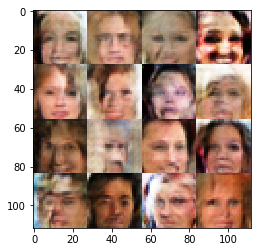

Epoch: 1, Batch: 5025: Discr train loss: 1.484, Gen train loss: 0.592
Epoch: 1, Batch: 5050: Discr train loss: 1.374, Gen train loss: 0.602
Epoch: 1, Batch: 5075: Discr train loss: 1.369, Gen train loss: 0.751
Epoch: 1, Batch: 5100: Discr train loss: 1.339, Gen train loss: 0.634


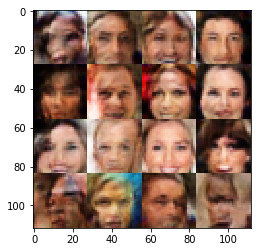

Epoch: 1, Batch: 5125: Discr train loss: 1.353, Gen train loss: 0.823
Epoch: 1, Batch: 5150: Discr train loss: 1.340, Gen train loss: 0.789
Epoch: 1, Batch: 5175: Discr train loss: 1.285, Gen train loss: 0.854
Epoch: 1, Batch: 5200: Discr train loss: 1.369, Gen train loss: 0.608


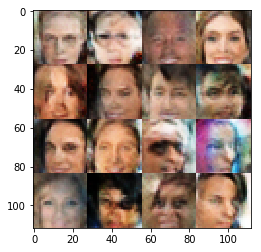

Epoch: 1, Batch: 5225: Discr train loss: 1.240, Gen train loss: 0.958
Epoch: 1, Batch: 5250: Discr train loss: 1.221, Gen train loss: 0.870
Epoch: 1, Batch: 5275: Discr train loss: 1.456, Gen train loss: 0.717
Epoch: 1, Batch: 5300: Discr train loss: 1.216, Gen train loss: 0.827


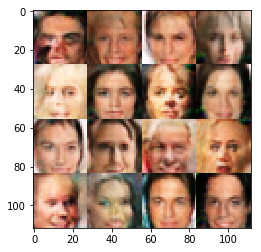

Epoch: 1, Batch: 5325: Discr train loss: 1.356, Gen train loss: 0.895
Epoch: 1, Batch: 5350: Discr train loss: 1.320, Gen train loss: 0.693
Epoch: 1, Batch: 5375: Discr train loss: 1.403, Gen train loss: 0.533
Epoch: 1, Batch: 5400: Discr train loss: 1.347, Gen train loss: 0.624


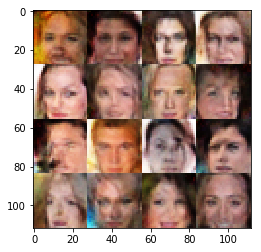

Epoch: 1, Batch: 5425: Discr train loss: 1.244, Gen train loss: 0.961
Epoch: 1, Batch: 5450: Discr train loss: 1.356, Gen train loss: 0.681
Epoch: 1, Batch: 5475: Discr train loss: 1.330, Gen train loss: 0.846
Epoch: 1, Batch: 5500: Discr train loss: 1.353, Gen train loss: 0.776


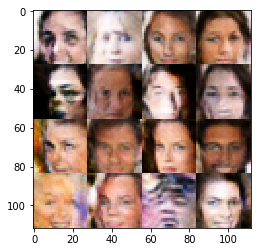

Epoch: 1, Batch: 5525: Discr train loss: 1.296, Gen train loss: 0.822
Epoch: 1, Batch: 5550: Discr train loss: 1.266, Gen train loss: 0.863
Epoch: 1, Batch: 5575: Discr train loss: 1.361, Gen train loss: 0.664
Epoch: 1, Batch: 5600: Discr train loss: 1.389, Gen train loss: 0.921


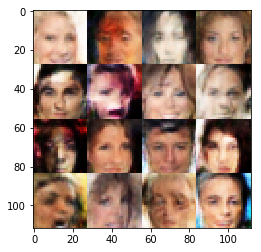

Epoch: 1, Batch: 5625: Discr train loss: 1.469, Gen train loss: 0.543
Epoch: 1, Batch: 5650: Discr train loss: 1.165, Gen train loss: 0.811
Epoch: 1, Batch: 5675: Discr train loss: 1.405, Gen train loss: 0.660
Epoch: 1, Batch: 5700: Discr train loss: 1.243, Gen train loss: 0.980


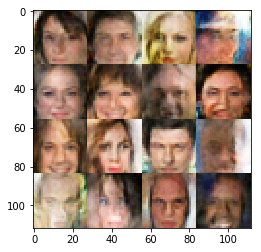

Epoch: 1, Batch: 5725: Discr train loss: 1.755, Gen train loss: 1.167
Epoch: 1, Batch: 5750: Discr train loss: 1.411, Gen train loss: 0.684
Epoch: 1, Batch: 5775: Discr train loss: 1.473, Gen train loss: 0.551
Epoch: 1, Batch: 5800: Discr train loss: 1.335, Gen train loss: 0.880


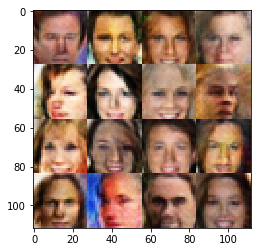

Epoch: 1, Batch: 5825: Discr train loss: 1.346, Gen train loss: 0.758
Epoch: 1, Batch: 5850: Discr train loss: 1.355, Gen train loss: 0.935
Epoch: 1, Batch: 5875: Discr train loss: 1.331, Gen train loss: 0.750
Epoch: 1, Batch: 5900: Discr train loss: 1.268, Gen train loss: 0.814


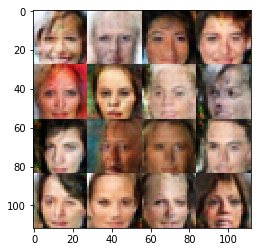

Epoch: 1, Batch: 5925: Discr train loss: 1.415, Gen train loss: 0.653
Epoch: 1, Batch: 5950: Discr train loss: 1.370, Gen train loss: 0.758
Epoch: 1, Batch: 5975: Discr train loss: 1.412, Gen train loss: 0.597
Epoch: 1, Batch: 6000: Discr train loss: 1.403, Gen train loss: 0.808


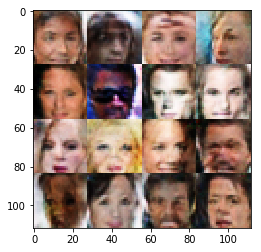

Epoch: 1, Batch: 6025: Discr train loss: 1.359, Gen train loss: 0.894
Epoch: 1, Batch: 6050: Discr train loss: 1.425, Gen train loss: 0.621
Epoch: 1, Batch: 6075: Discr train loss: 1.417, Gen train loss: 0.576
Epoch: 1, Batch: 6100: Discr train loss: 1.392, Gen train loss: 0.681


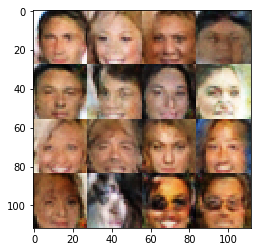

Epoch: 1, Batch: 6125: Discr train loss: 1.235, Gen train loss: 0.826
Epoch: 1, Batch: 6150: Discr train loss: 1.314, Gen train loss: 0.961
Epoch: 1, Batch: 6175: Discr train loss: 1.371, Gen train loss: 0.851
Epoch: 1, Batch: 6200: Discr train loss: 1.302, Gen train loss: 0.777


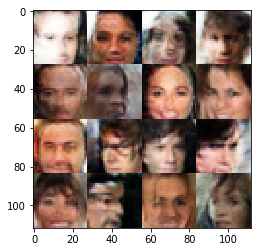

Epoch: 1, Batch: 6225: Discr train loss: 1.305, Gen train loss: 1.107
Epoch: 1, Batch: 6250: Discr train loss: 1.289, Gen train loss: 0.663
Epoch: 1, Batch: 6275: Discr train loss: 1.222, Gen train loss: 1.065
Epoch: 1, Batch: 6300: Discr train loss: 1.329, Gen train loss: 0.932


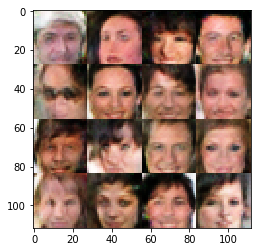

Epoch: 1, Batch: 6325: Discr train loss: 1.331, Gen train loss: 1.025


In [14]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.